In [1]:
%pip install sympy


Note: you may need to restart the kernel to use updated packages.


<h2>Importación</h2>

In [2]:
import numpy as np
import psutil
import math
from scipy.optimize import dual_annealing
import sympy
import subprocess
import glob
from queue import PriorityQueue
import re
import os 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

<h1>->Optimización de silueta NACA 2411 </h>

<h2>1. Ingreso de coordenadas [x,y] para extrados e intrados</h2>

Nota: Se elimino el valor de conexión entre extrados e intrados [0,0]

-> Extrados

In [3]:
xe=[1.000077, 0.905222, 0.655569, 0.344747, 0.092287, 0.022253]
ye=[0.001152, 0.018594, 0.053894, 0.074234, 0.050499,0.026004]
print(" xe","\t"," ye")
matrix_length = len(xe)
for i in range(matrix_length):
    print(f"{xe[i]:.3f}","\t",f"{ye[i]:.3f}") 

 xe 	  ye
1.000 	 0.001
0.905 	 0.019
0.656 	 0.054
0.345 	 0.074
0.092 	 0.050
0.022 	 0.026


-> Intrados

In [4]:
xi=[0.098696, 0.208669, 0.346236, 0.653448, 0.903795, 0.999923]
yi=[-0.03368, -0.037542, -0.034976, -0.021091, -0.006875, -0.001152]
print(" xi","\t"," yi")
matrix_length = len(xi)
for i in range(matrix_length):
    print(f"{xi[i]:.3f}","\t",f"{yi[i]:.3f}") 

 xi 	  yi
0.099 	 -0.034
0.209 	 -0.038
0.346 	 -0.035
0.653 	 -0.021
0.904 	 -0.007
1.000 	 -0.001


<h2>2. Sistema de ecuaciones para encontrar los coeficientes "a" del extrados e intrados</h2>

->Extrados

In [5]:
A = np.array([[pow(xe[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(ye)
sol_e = np.linalg.solve(A, b)
print(sol_e)

[ 0.17657898 -0.09815569 -0.15177792 -0.01308316  0.1986828  -0.11107752]


-> Intrados

In [6]:
A = np.array([[pow(xi[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(yi)
sol_i = np.linalg.solve(A, b)
print(sol_i)

[-0.13752259  0.35466163 -0.53503907  0.57857988 -0.3498213   0.0879941 ]


<h2>NOTA: aquí se verifican los resultados posteriores para y"emáx, y"imin, x_emax & x_imin

-> Calcular X_emax 


In [7]:
xee = sympy.symbols('xee')
fe = sum(sol_e[i]*xee**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fe, xee)

sol = sympy.solve(dy, xee)

def is_sol(xee):
    if sympy.im(xee) != 0:
        return False
    if xee < 0 or xee > 1:
        return False
    return True

x_eemax =float([xee for xee in sol if is_sol(xee)][0])
print("x_eemax=",x_eemax)
display(fe)

x_eemax= 0.3454054020595761


0.176578975045468*xee**0.5 - 0.0981556898255968*xee**1.5 - 0.151777919394591*xee**2.5 - 0.0130831648208801*xee**3.5 + 0.198682798462746*xee**4.5 - 0.111077518624468*xee**5.5

-> Calcular X_imax 

In [8]:
xii = sympy.symbols('xii')
fi = sum(sol_i[i]*xii**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fi, xii)

sol = sympy.solve(dy, xii)

def is_sol(xii):
    if sympy.im(xii) != 0:
        return False
    if xii < 0 or xii > 1:
        return False
    return True

x_imin = float([xii for xii in sol if is_sol(xii)][0])
print("x_imin=",x_imin)
display(fi)



x_imin= 0.21076554310772525


-0.137522586613543*xii**0.5 + 0.354661632344435*xii**1.5 - 0.535039073008173*xii**2.5 + 0.578579884638977*xii**3.5 - 0.349821301634883*xii**4.5 + 0.0879940976755725*xii**5.5

<h2>3. Calculo de los parametros del perfil original

-> Variables simbolicas, no son numeros. Se crean para desarrollar el sistema de ecuaciones

In [9]:
y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax, x_imax, dy_emax, dy_imax, r_ba=sympy.symbols("y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax,x_imax, dy_emax, dy_imax, r_ba")

->Los valores de ae & ai se vuelven simbolicos para emplearlo en el sistema (Iteradores)

In [10]:
ae=sympy.symbols("ae:6")
ai=sympy.symbols("ai:6")
k=sympy.symbols("k",integer=True)


-> Ecuaciones a resolver

In [11]:
eq1=sympy.sqrt(2*r_ba)+ai[0]
#extrados
eq2 =sum([ae[k-1]*pow(x_emax, k-0.5) for k in range(1, 7)])-y_emax
eq3=sum([(k-0.5)*ae[k-1]*pow(x_emax, k-1.5) for k in range(1, 7)])
eq4=sum([(k-1.5)*(k-0.5)*ae[k-1]*pow(x_emax, k-2.5) for k in range(1, 7)])-dy_emax
eq5=sum([ae[k-1] for k in range(1, 7)])-y_bs-0.5*deltay_bs    #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq6=sum([(k-0.5)*ae[k-1] for k in range(1, 7)])-sympy.tan((2*alpha-beta)/2)
#intrados 
eq7=sum([ai[k-1]*pow(x_imax, k-0.5) for k in range(1, 7)])-y_imax
eq8=sum([(k-0.5)*ai[k-1]*pow(x_imax, k-1.5) for k in range(1, 7)])
eq9=sum([(k-1.5)*(k-0.5)*ai[k-1]*pow(x_imax, k-2.5) for k in range(1, 7)])-dy_imax
eq10=sum([ai[k-1] for k in range(1, 7)])-y_bs-0.5*deltay_bs   #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq11=sum([(k-0.5)*ai[k-1] for k in range(1, 7)])-sympy.tan((2*alpha+beta)/2)
#Fueron igualadas a 0 para crear el sistema de solución con ayuda de sympy

-> Impresión y verificación 

In [12]:
display(eq1)
display(eq2)
display(eq3)
display(eq4)
display(eq5)
display(eq6)
display(eq7)
display(eq8)
display(eq9)
display(eq10)
display(eq11)

ai0 + sqrt(2)*sqrt(r_ba)

ae0*x_emax**0.5 + ae1*x_emax**1.5 + ae2*x_emax**2.5 + ae3*x_emax**3.5 + ae4*x_emax**4.5 + ae5*x_emax**5.5 - y_emax

0.5*ae0/x_emax**0.5 + 1.5*ae1*x_emax**0.5 + 2.5*ae2*x_emax**1.5 + 3.5*ae3*x_emax**2.5 + 4.5*ae4*x_emax**3.5 + 5.5*ae5*x_emax**4.5

-0.25*ae0/x_emax**1.5 + 0.75*ae1/x_emax**0.5 + 3.75*ae2*x_emax**0.5 + 8.75*ae3*x_emax**1.5 + 15.75*ae4*x_emax**2.5 + 24.75*ae5*x_emax**3.5 - dy_emax

ae0 + ae1 + ae2 + ae3 + ae4 + ae5 - 0.5*deltay_bs - y_bs

0.5*ae0 + 1.5*ae1 + 2.5*ae2 + 3.5*ae3 + 4.5*ae4 + 5.5*ae5 - tan(alpha - beta/2)

ai0*x_imax**0.5 + ai1*x_imax**1.5 + ai2*x_imax**2.5 + ai3*x_imax**3.5 + ai4*x_imax**4.5 + ai5*x_imax**5.5 - y_imax

0.5*ai0/x_imax**0.5 + 1.5*ai1*x_imax**0.5 + 2.5*ai2*x_imax**1.5 + 3.5*ai3*x_imax**2.5 + 4.5*ai4*x_imax**3.5 + 5.5*ai5*x_imax**4.5

-0.25*ai0/x_imax**1.5 + 0.75*ai1/x_imax**0.5 + 3.75*ai2*x_imax**0.5 + 8.75*ai3*x_imax**1.5 + 15.75*ai4*x_imax**2.5 + 24.75*ai5*x_imax**3.5 - dy_imax

ai0 + ai1 + ai2 + ai3 + ai4 + ai5 - 0.5*deltay_bs - y_bs

0.5*ai0 + 1.5*ai1 + 2.5*ai2 + 3.5*ai3 + 4.5*ai4 + 5.5*ai5 - tan(alpha + beta/2)

<h2>->Simplificación con suposición

In [13]:
eq=[eq1, eq2,  eq4 , eq6, eq7, eq9, eq11] #Se crea un grupo para todas las ecuaciones, NOTA SE ELIMINA 3,5,8, 10 PORQUE VALEN 0!!!!
for i in range(len(eq)):
    for j in range(len(sol_e)):
        eq[i]=eq[i].subs(ae[j],sol_e[j])
    for j in range(len(sol_i)):
        eq[i]=eq[i].subs(ai[j],sol_i[j])
    eq[i]=eq[i].subs({ 'x_emax':x_eemax, 'x_imax':x_imin, 'deltay_bs':0, 'y_bs':0 }) #con derivadas se determina rapidamente estos valores para ayudar al solver

for e in eq:
    display(e) #todo esta igualado a cero

sqrt(2)*sqrt(r_ba) - 0.137522586613543

0.0742341187674546 - y_emax

-dy_emax - 0.54763595477253

-tan(alpha - beta/2) - 0.201033681927436

-y_imax - 0.0375428859238944

0.400447484269755 - dy_imax

0.0604347487845426 - tan(alpha + beta/2)

<h2>->Solver </h2>

In [14]:
def sistema_ecuaciones(x):
    eqv = list(map(lambda eq: float(eq.subs({  #programación funcional 
       'r_ba': x[0],
       'y_emax': x[1],
       'dy_emax': x[2],
       'alpha': x[3],
       'beta':x[5],
       'dy_imax': x[6],
       'y_imax':x[4]
    })),eq))

    return eqv


-> Se crean variables cero para permitir a Python resolver de forma lineal, con esto, se logra emplear el solver de "fsolve"

In [15]:
# Valores iniciales para las variables
x0 = np.zeros(len(eq))

# Resolver el sistema de ecuaciones
solucion = fsolve(sistema_ecuaciones, x0)

# Mostrar las soluciones aproximadas
print("Soluciones aproximadas:")
for i in solucion:
  print("%.4f" % i)


Soluciones aproximadas:
0.0095
0.0742
-0.5476
-0.0690
-0.0375
0.2588
0.4004


In [16]:
sol=np.array([*solucion]) #sprad operador de esparcir 


<h2>4. Calculo de los parametros de los perfiles variados 

In [17]:
def evalue_combi(i,j,k):
    i, j, k = i / 100, j/100, k/100
    sol[2]=solucion[2]*i
    sol[3]=solucion[3]*j
    sol[6]=solucion[6]*k
    eq1=[1.0,0,0,0,0,0]
    #extrados
    eq2 =[pow(x_eemax, k-0.5) for k in range(1, 7)]
    eq3=[(k-0.5)*pow(x_eemax, k-1.5) for k in range(1, 7)]
    eq4=[(k-1.5)*(k-0.5)*pow(x_eemax, k-2.5) for k in range(1, 7)]
    eq5=[1 for k in range(1, 7)]  #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq6=[(k-0.5) for k in range(1, 7)]
    #intrados 
    eq7=[pow(x_imin, k-0.5) for k in range(1, 7)]
    eq8=[(k-0.5)*pow(x_imin, k-1.5) for k in range(1, 7)]
    eq9=[(k-1.5)*(k-0.5)*pow(x_imin, k-2.5) for k in range(1, 7)]
    eq10=[1 for k in range(1, 7)] #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq11=[(k-0.5) for k in range(1, 7)]
    eq12=[-1.0,0,0,0,0,0]

    ve=[math.sqrt(2*sol[0]),sol[1],0,sol[2],0,math.tan((2*sol[3]-sol[5])/2)]
    vi=[sol[4],0,sol[6],0,math.tan((2*sol[3]+sol[5])/2),math.sqrt(2*sol[0])]     
    Ae=[eq1,eq2,eq3,eq4,eq5,eq6]
    Ai=[eq7,eq8,eq9,eq10,eq11,eq12]
    vi
    sole=np.linalg.solve(Ae,ve)

    soli=np.linalg.solve(Ai,vi)

    return(sole, soli)

<h3>-> Declaración de las funciones de los nuevos perfiles

In [18]:
def get_coord_combi(i,j,k):
    sole,soli=evalue_combi(i,j,k)
    x=np.arange(0,1,0.01)
    fee = sum(sole[i]*x**(i + 0.5) for i in range(0, 6))
    fii = sum(soli[i]*x**(i + 0.5) for i in range(0, 6))
    xx=[*x[::-1],*x]
    yy=[*fee[::-1],*fii]
    return(xx,yy)



Creación de las impresiones de los nuevos perfiles

In [19]:
def plot_combi(i,j,k):
    xx,yy=get_coord_combi(i,j,k)
    plt.plot(xx,yy)


<h3>->Perfil base 2411

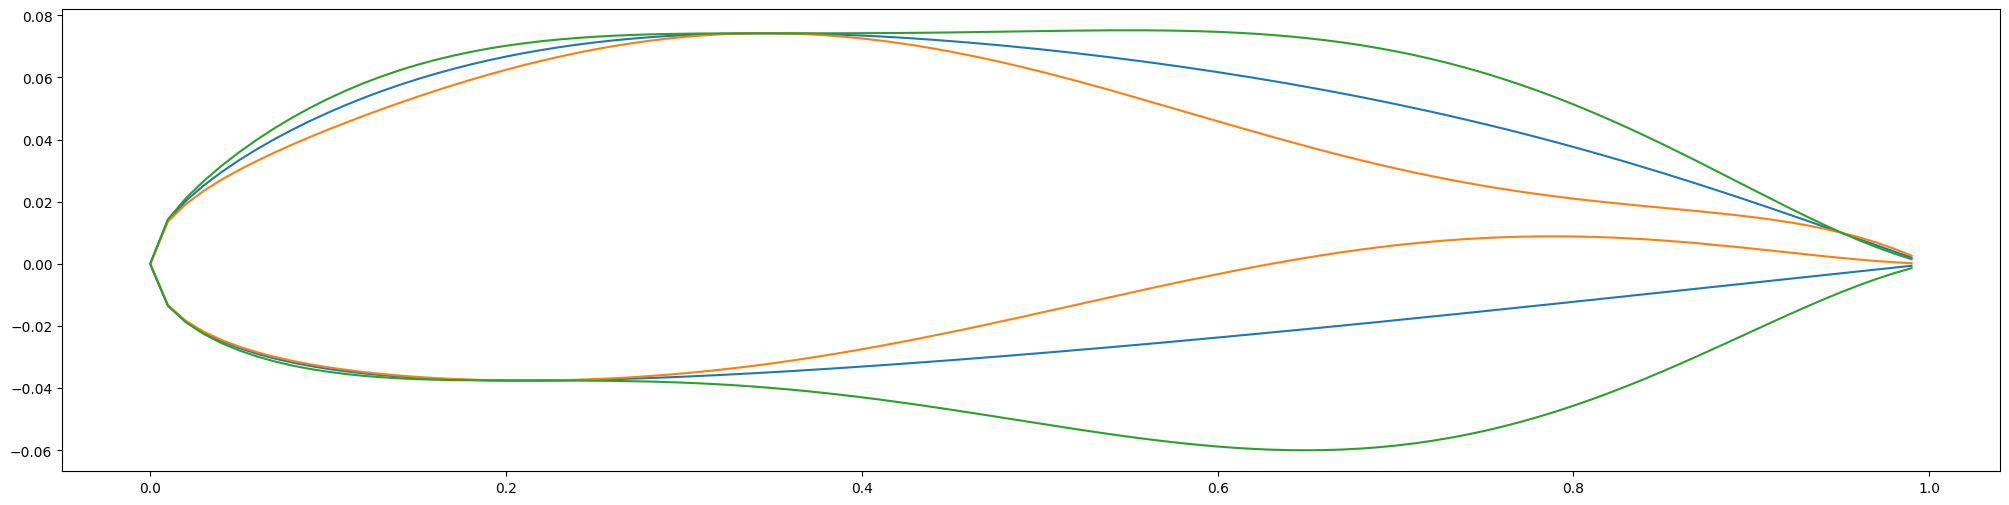

In [20]:
plt.figure(figsize=(25,6))
plot_combi(100,100,100)
plot_combi(210,210,150)
plot_combi(10,10,10)

<h3>->Impresión de varios perfiles

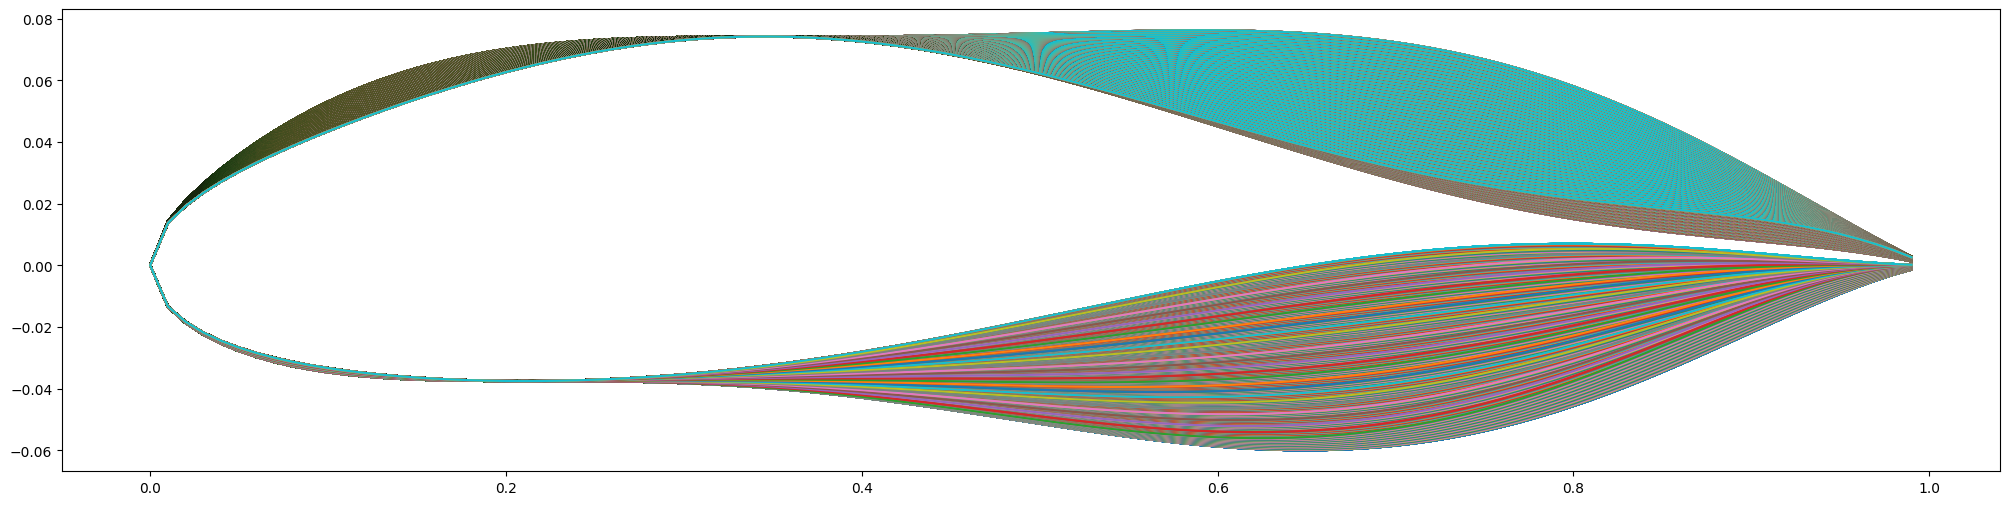

In [21]:
plt.figure(figsize=(25,6))
for i in range(10,210,5):
    for j in range(10,210,5):
        for k in range(10,150,5):
            plot_combi(i,j,k)

<h2>5. Creación de documentos para la simulación en Xfoil

Geometría del perfil

In [22]:
def create_coord_file(xx,yy,fname):
    test_result=""
    for i in range(len(xx)):
        x=xx[i]
        y=yy[i]
        test_result += f"{x:.6f}" + (" "*(4 if y >= 0 else 3)) + f"{y:.6f}\n"
    test_result
    file=open(fname + ".dat","w")
    file.write(test_result)
    file.close()

Datos de simulación que ingresan a Xfoil y creación de archivo "resultados"

In [23]:
def run_simulation(i,j,k,fname=None):
    xx,yy=get_coord_combi(i,j,k)
    if fname is None:
        fname=f"barrido06/sim_{i}_{j}_{k}"
    create_coord_file(xx,yy,fname)
    strname = str(fname) + '.txt'
    airfoil_name = fname
    alpha_i = 0
    alpha_f = 9
    alpha_step = 1
    Re = 1000000
    n_iter = 100

    # %% XFOIL input file writer 

    if os.path.exists(strname):
        os.remove(strname)

    input_file = open(fname+".in", 'w')
    input_file.write("LOAD {0}.dat\n".format(airfoil_name))
    input_file.write(airfoil_name + '\n')
    input_file.write("PANE\n")
    input_file.write("OPER\n")
    input_file.write("Visc {0}\n".format(Re))
    input_file.write("PACC\n")
    input_file.write(strname+"\n\n ")
    input_file.write("ITER {0}\n".format(n_iter))
    input_file.write("ASeq {0} {1} {2}\n".format(alpha_i, alpha_f,
                                                alpha_step))
    input_file.write("\n\n")
    input_file.write("quit\n")
    input_file.close()

    process = subprocess.Popen("xfoil.exe < " + fname + ".in", shell=True)

    try:
        process.wait(timeout=60)
    except subprocess.TimeoutExpired:
        for child in psutil.Process(process.pid).children(recursive=True):
            child.kill()
        process.kill()

        print("killed " + fname + " after timeout")
    

Se indica a Xfoil que corra los datos anteriores

In [24]:
for i in range(10,210,5):
   for j in range(10,210,5):
      for k in range(10,150,5):
         run_simulation(i,j,k)


<h2>6. Lectura de archivos para comparar el mejor


Lecutra de archivo

In [39]:
def get_params_from_fname(fname):
    params = re.search(r'sim_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)\.txt', fname)
    return [params.group(i) for i in range(1, 4)]

Ingreso al documento para separar las columnas de los archivos 

In [41]:
def filter_empty(values):
  return list(filter(lambda line: False if line == "" else True, values))

def get_values(line):
  values = re.split(r'\s+', line)
  values = filter_empty(values)
  return list(map(float, values))

def get_table(file):
  match_ = re.search(r'((?:-{2,} *)+)', file)
  match_.groups(1)
  
  table = file[match_.end(1): len(file)]
  lines = table.split("\n")
  lines = filter_empty(lines)

  values = list(map(get_values, lines))
  return values


Calculo de la eficiencia dentro de los archivos 

In [42]:
def get_value(table):
    cl_values=list(map(lambda line: line[1]/line[2], table))
    max=np.max(cl_values)  
    return max
    #return cl_values[6]

Por medio de "Queue" biblioteca de python se crea una lista de prioridad que permite ver el rango entre los parametros 

In [43]:
X=PriorityQueue()


In [44]:
for name in glob.glob('./barrido06/sim*.txt'):
    f = open(name, "r")
    content=f.read()
    params=get_params_from_fname(name)
    values = get_table(content)
    result=get_value(values)
    X.put((-result,params))#El orden da negativo pero no es el valor real, son positivos 
    f.close()

<h1> 7. Lista ordenada de mejores eficiencias a peores

In [45]:
n = 0
top=[]
while not X.empty():
    priority,params = X.get()
    priority*=-1
    top.append((priority,params))
    n += 1
display(top)

[(161.9029126213592, ['90', '50', '90']),
 (161.71610169491524, ['65', '90', '90']),
 (160.3361344537815, ['186.37023887', '34.31385193', '82.10512816']),
 (159.96661101836395, ['110', '205', '130']),
 (157.46691871455573, ['110', '160', '85']),
 (157.12305025996534, ['67.4921009', '163.11718181', '106.7957018']),
 (155.76449912126537, ['140', '35', '80']),
 (154.6048109965636, ['120', '45', '80']),
 (154.18727915194347, ['150', '20', '85']),
 (153.5334476843911, ['120', '65', '80']),
 (152.96950240770465, ['140', '190', '140']),
 (152.48496993987976, ['93.02032086', '94.83778533', '72.48077132']),
 (152.40901213171577, ['140', '30', '90']),
 (152.03991130820398, ['20', '90', '91']),
 (151.72240802675586, ['20', '185', '105']),
 (151.61290322580646, ['15', '30', '85']),
 (151.0374149659864, ['125', '70', '85']),
 (150.976, ['150', '170', '145']),
 (150.90016366612113, ['145', '50', '115']),
 (150.79661016949154, ['150', '50', '100']),
 (150.731319554849, ['160', '190', '145']),
 (150.7

<h2> Graficas que muestran el comportamiento de las diferentes combinaciones

Separación de formato 

In [46]:
CL=[]
I=[]
J=[]
K=[]
for cl, (i, j, k) in top:
    CL.append(cl)
    I.append(float(i))
    J.append(float(j))
    K.append(float(k))


Impresión de grafico que muestra el comportamiento de los parametros combinados y la eficiencia de cada combinación


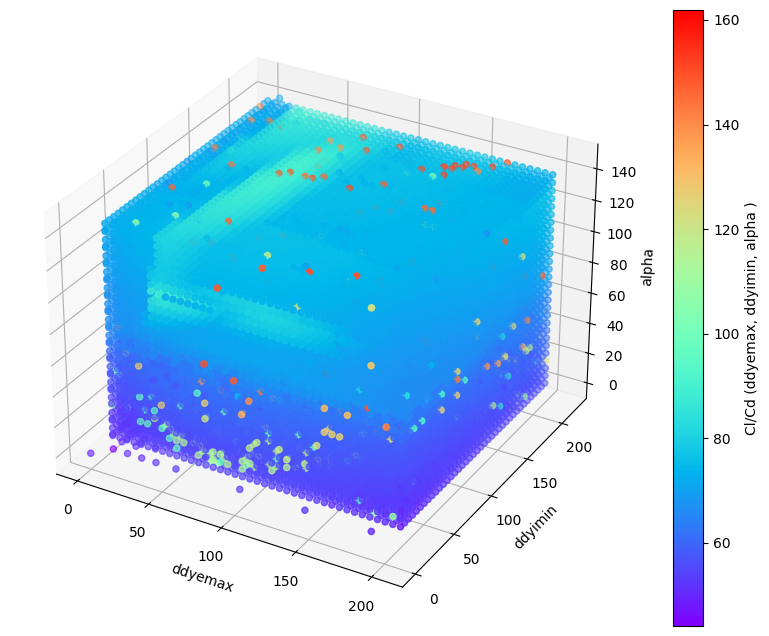

In [47]:
# Create a colormap
cmap = plt.get_cmap('rainbow')  # You can change the colormap as needed

# Create a figure and 3D axes
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
scatter = ax.scatter(I, J, K, c=CL, cmap=cmap, marker='o')

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cl/Cd (ddyemax, ddyimin, alpha )')

# Set axis labels
ax.set_xlabel('ddyemax')
ax.set_ylabel('ddyimin')
ax.set_zlabel('alpha')

# Show the plot
plt.show()

In [33]:
uid=int(0)
def evalue_sim(x):
    global uid
    i,j,k=x
    name=f"results_opt/_sim_{uid}"
    name2=name
    run_simulation(i,j,k,fname=name) #asignar a la fuerza un nombre 
    name+=".txt"
    f = open(name, "r")
    content=f.read()
    values = get_table(content)
    result=get_value(values)
    f.close()
    os.remove(name)
    os.remove(name2+".dat")
    try:
        os.remove(name2+".in")
    except PermissionError:
        print("PermissionError")
    uid+=1
    return result

In [34]:
rangei=(10,210)
rangej=(10,210)
rangek=(10,150)
maxim = dual_annealing(lambda p:-evalue_sim(p), bounds=(rangei, rangej, rangek),maxiter=1000)
maxim

killed results_opt/_sim_612 after timeout
PermissionError
killed results_opt/_sim_1896 after timeout
PermissionError
killed results_opt/_sim_1913 after timeout
PermissionError
killed results_opt/_sim_2001 after timeout
PermissionError
killed results_opt/_sim_2232 after timeout
PermissionError
killed results_opt/_sim_2271 after timeout
PermissionError
killed results_opt/_sim_2336 after timeout
PermissionError
killed results_opt/_sim_2368 after timeout
PermissionError
killed results_opt/_sim_2391 after timeout
PermissionError
killed results_opt/_sim_3162 after timeout
PermissionError
killed results_opt/_sim_3653 after timeout
PermissionError
killed results_opt/_sim_4015 after timeout
PermissionError
killed results_opt/_sim_4069 after timeout
PermissionError
killed results_opt/_sim_4732 after timeout
PermissionError
killed results_opt/_sim_5110 after timeout
PermissionError
killed results_opt/_sim_5426 after timeout
PermissionError
killed results_opt/_sim_5926 after timeout
PermissionErro

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -152.48496993987976
       x: [ 9.302e+01  9.484e+01  7.248e+01]
     nit: 1000
    nfev: 6061
    njev: 15
    nhev: 0

In [36]:
maxim.x

array([93.02032086, 94.83778533, 72.48077132])

In [37]:
evalue_sim(maxim.x)

152.48496993987976

In [38]:
run_simulation(93.02032086, 94.83778533, 72.48077132)
run_simulation(100,100,100)